### **Lab3 Hui Li**

**Load Data**

Original data is downloaded from https://github.com/csaw-hackml/CSAW-HackML-2020. 
The Data is manully uploaded to my google drive.

In [1]:
from google.colab import drive 
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
import keras
import keras.backend as K
from keras import models
from keras.models import Model
from keras import initializers
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/content/CSAW-HackML-2020')
import architecture
from architecture import Net
from eval import data_loader
from eval import data_preprocess


**Load and process data**

In [7]:
x_val_cl, y_val_cl = data_loader('/content/CSAW-HackML-2020/lab3/data/cl/valid.h5')
x_test_cl, y_test_cl = data_loader('/content/CSAW-HackML-2020/lab3/data/cl/test.h5')
x_val_bd, y_val_bd = data_loader('/content/CSAW-HackML-2020/lab3/data/bd/bd_valid.h5')
x_test_bd, y_test_bd = data_loader('/content/CSAW-HackML-2020/lab3/data/bd/bd_test.h5')
# count how many classes
num_class_val = len(np.unique(y_val_cl)) 
num_class_test = len(np.unique(x_test_cl)) 
print('Number of classes in Validation dataset:', num_class_val) 
print('Number of classes in Test dataset:', num_class_test)

Number of classes in Validation dataset: 1283
Number of classes in Test dataset: 256


**Load and Import Model**

In [8]:
bd_model = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')
K.clear_session()
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

Here we use the eval code from souce,to compute metrics on valid data before pruning:

In [9]:
#!python /content/CSAW-HackML-2020/lab3/eval.py /content/CSAW-HackML-2020/lab3/data/cl/valid.h5 /content/CSAW-HackML-2020/lab3/data/bd/bd_valid.h5 /content/CSAW-HackML-2020/lab3/models/bd_net.h5

**Define the Goodnet Class**

In [10]:
class GoodNet(Model):
  def __init__(self, bd_model, bd_model_pruned):
    super(GoodNet, self).__init__()
    self.bd_model = bd_model
    self.bd_model_pruned = bd_model_pruned

  def predict(self, x):
    bd_model_pred = np.argmax(self.bd_model.predict(x), axis=1)
    bd_model_pruned_pred = np.argmax(self.bd_model_pruned.predict(x), axis=1)
    pred = np.zeros(len(bd_model_pred))
    pred[np.where(bd_model_pred==bd_model_pruned_pred)]=bd_model_pred[np.where(bd_model_pred==bd_model_pruned_pred)]
    pred[np.where(bd_model_pred!=bd_model_pruned_pred)]=int(1282+1)
    return pred

**Prune the Model**

Get the last pooling layer(pool3) and average activation values over the entire validation set: 

In [11]:
pool_3 = Model(inputs=bd_model.input, outputs=bd_model.get_layer('pool_3').output)
pool_3_output = np.mean(pool_3.predict(x_val_cl), axis=0)
index_order = np.argsort(np.sum(pool_3_output, axis=(0, 1))) #sort in increasing order and return index

Here I copy the function of compute acc and eval goodnet from eval.py:

In [12]:
def compute_acc(y, y_pred):
  clean_accuracy = np.mean(np.equal(y_pred, y))*100
  return clean_accuracy

def evaluate_gd(gd_model, cl_x_test, cl_y_test, bd_x_test, bd_y_test):
  cl_label_p = gd_model.predict(cl_x_test)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
  bd_label_p = gd_model.predict(bd_x_test)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  return clean_accuracy, asr

In [13]:
bd_model = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')
bd_model_pruned = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')

# prune conv3 layer and reduce the pool3 layer channel
conv_3_layer = bd_model_pruned.get_layer('conv_3')
weight, bias = conv_3_layer.get_weights()
round = 0
clean_accuracy_list=[] 
attack_success_rate_list =[]

goodnet = GoodNet(bd_model, bd_model_pruned)
clean_accuracy_list.append(evaluate_gd(goodnet, x_test_cl, y_test_cl, x_test_bd, y_test_bd)[0])
attack_success_rate_list.append(evaluate_gd(goodnet, x_test_cl, y_test_cl, x_test_bd, y_test_bd)[1])
for index in index_order:
  #prune
  round+=1
  weight[:, :, :, index] = 0
  bias[index] = 0
  conv_3_layer.set_weights([weight, bias])
  y_val_cl_pred = np.argmax(bd_model_pruned.predict(x_val_cl), axis=1)
  val_cl_acc = compute_acc(y_val_cl, y_val_cl_pred)
  acc_diff = np.round(98.64899974019225 - val_cl_acc, 1) #98.64899974019225 is getting from the original evel.py
  if acc_diff>=2:
    bd_model_pruned.save('/content/CSAW-HackML-2020/lab3/models/bd_net_prune_'+'acc'+str(acc_diff)+'.h5')
  print('Round:', round, 'val_cl_acc:', val_cl_acc, 'acc_drop:', acc_diff)

  #compute metrics on test data
  goodnet = GoodNet(bd_model, bd_model_pruned)
  clean_accuracy, attack_success_rate = evaluate_gd(goodnet, x_test_cl, y_test_cl, x_test_bd, y_test_bd)
  clean_accuracy_list.append(clean_accuracy)
  attack_success_rate_list.append(attack_success_rate)
  print('Clean Accuracy:', clean_accuracy, 'Attack Success Rate:', attack_success_rate)

Round: 1 val_cl_acc: 98.64899974019225 acc_drop: 0.0
Clean Accuracy: 98.62042088854248 Attack Success Rate: 100.0
Round: 2 val_cl_acc: 98.64899974019225 acc_drop: 0.0
Clean Accuracy: 98.62042088854248 Attack Success Rate: 100.0
Round: 3 val_cl_acc: 98.64899974019225 acc_drop: 0.0
Clean Accuracy: 98.62042088854248 Attack Success Rate: 100.0
Round: 4 val_cl_acc: 98.64899974019225 acc_drop: 0.0
Clean Accuracy: 98.62042088854248 Attack Success Rate: 100.0
Round: 5 val_cl_acc: 98.64899974019225 acc_drop: 0.0
Clean Accuracy: 98.62042088854248 Attack Success Rate: 100.0
Round: 6 val_cl_acc: 98.64899974019225 acc_drop: 0.0
Clean Accuracy: 98.62042088854248 Attack Success Rate: 100.0
Round: 7 val_cl_acc: 98.64899974019225 acc_drop: 0.0
Clean Accuracy: 98.62042088854248 Attack Success Rate: 100.0
Round: 8 val_cl_acc: 98.64899974019225 acc_drop: 0.0
Clean Accuracy: 98.62042088854248 Attack Success Rate: 100.0
Round: 9 val_cl_acc: 98.64899974019225 acc_drop: 0.0
Clean Accuracy: 98.62042088854248 A

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Round: 45 val_cl_acc: 95.75647354291158 acc_drop: 2.9
Clean Accuracy: 95.74434918160561 Attack Success Rate: 100.0
Round: 46 val_cl_acc: 95.20221702606739 acc_drop: 3.4
Clean Accuracy: 95.34684333593141 Attack Success Rate: 99.97661730319564
Round: 47 val_cl_acc: 94.7172425738287 acc_drop: 3.9
Clean Accuracy: 94.90257209664848 Attack Success Rate: 99.98441153546376
Round: 48 val_cl_acc: 92.09318437689443 acc_drop: 6.6
Clean Accuracy: 92.1278254091972 Attack Success Rate: 99.98441153546376
Round: 49 val_cl_acc: 91.49562656967177 acc_drop: 7.2
Clean Accuracy: 91.58222915042869 Attack Success Rate: 99.98441153546376
Round: 50 val_cl_acc: 91.01931237550879 acc_drop: 7.6
Clean Accuracy: 91.13016367887764 Attack Success Rate: 99.97661730319564
Round: 51 val_cl_acc: 89.17467740538669 acc_drop: 9.5
Clean Accuracy: 89.68043647700702 Attack Success Rate: 80.6469212782541
Round: 52 val_cl_acc: 84.43751623798389 acc_drop: 14.2
Clean Accuracy: 84.3335931410756 Attack Success Rate: 77.20966484801247

### **Result**

Repaired networks for X={2%,4%,10%}.

In [15]:
!git clone https://github.com/lihui199688/ML_Security_Lab3.git

Cloning into 'ML_cyber_lab3'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 47 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (47/47), done.


**X=2%**



In [16]:
bd_model = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')
bd_model_pruned = keras.models.load_model('/content/ML_Security_Lab3/Model/bd_net_prune_acc2.9.h5')
goodnet = GoodNet(bd_model, bd_model_pruned)
pred_cl = goodnet.predict(x_test_cl)
print('Clean Classification accuracy:', np.mean(np.equal(pred_cl, y_test_cl))*100)
pred_bd = goodnet.predict(x_test_bd)
print('Attack Success Rate:', np.mean(np.equal(pred_bd, y_test_bd))*100)

Clean Classification accuracy: 95.74434918160561
Attack Success Rate: 100.0


**X=4%**

In [17]:
bd_model = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')
bd_model_pruned = keras.models.load_model('/content/ML_Security_Lab3/Model/bd_net_prune_acc6.6.h5')
goodnet = GoodNet(bd_model, bd_model_pruned)
pred_cl = goodnet.predict(x_test_cl)
print('Clean Classification accuracy:', np.mean(np.equal(pred_cl, y_test_cl))*100)
pred_bd = goodnet.predict(x_test_bd)
print('Attack Success Rate:', np.mean(np.equal(pred_bd, y_test_bd))*100)

Clean Classification accuracy: 92.1278254091972
Attack Success Rate: 99.98441153546376


**X=10%**

In [18]:
bd_model = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')
bd_model_pruned = keras.models.load_model('/content/ML_Security_Lab3/Model/bd_net_prune_acc14.2.h5')
goodnet = GoodNet(bd_model, bd_model_pruned)
pred_cl = goodnet.predict(x_test_cl)
print('Clean Classification accuracy:', np.mean(np.equal(pred_cl, y_test_cl))*100)
pred_bd = goodnet.predict(x_test_bd)
print('Attack Success Rate:', np.mean(np.equal(pred_bd, y_test_bd))*100)

Clean Classification accuracy: 84.3335931410756
Attack Success Rate: 77.20966484801247


**X=30%**

In [30]:
bd_model = keras.models.load_model('/content/CSAW-HackML-2020/lab3/models/bd_net.h5')
bd_model_pruned = keras.models.load_model('/content/ML_Security_Lab3/Model/bd_net_prune_acc43.8.h5')
goodnet = GoodNet(bd_model, bd_model_pruned)
pred_cl = goodnet.predict(x_test_cl)
print('Clean Classification accuracy:', np.mean(np.equal(pred_cl, y_test_cl))*100)
pred_bd = goodnet.predict(x_test_bd)
print('Attack Success Rate:', np.mean(np.equal(pred_bd, y_test_bd))*100)

Clean Classification accuracy: 54.67653936087296
Attack Success Rate: 6.96024941543258


Plot the accuracy on clean test data and the attack success rate (on backdoored testdata) as a function of the fraction of channels pruned. 

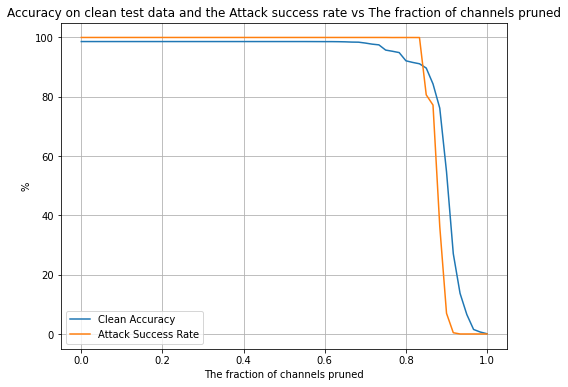

In [29]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,61)/60, clean_accuracy_list, label='Clean Accuracy')
plt.plot(np.arange(0,61)/60, attack_success_rate_list, label='Attack Success Rate')
plt.title('Accuracy on clean test data and the Attack success rate vs The fraction of channels pruned')
plt.legend()
plt.xlabel('The fraction of channels pruned')
plt.ylabel('%')
plt.grid('on')











**GitHub Link**

https://github.com/lihui199688/ML_Security_Lab3
